### Importar Bibliotecas

In [1]:
library(tseries) 
library(tidyverse)
library(dplyr)
library(readxl)
library("TTR")
library(forecast)
library(lmtest)
library(FitAR)
library(randtests)
library(seasonalview)
library(moments)
library(kableExtra)



Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice

Loading required package: leaps

Loading required package: ltsa

Loading required package: bestglm


Attaching package: ‘FitAR’


The following object is masked from ‘package:forecast’:

    BoxCox




ERROR: Error in library(randtests): there is no package called ‘randtests’


In [7]:
tema = theme(panel.background = element_rect(fill='black'),
        panel.grid =element_blank(),
        plot.background = element_rect(fill='black'),
        axis.text = element_text(colour='white',size=10), 
        #panel.grid.major.x = element_line(colour='grey60',linetype = 4,size = 0.2),
        panel.grid.major.y = element_line(colour='white',linetype = 1,size = 0.1),
        axis.line = element_line(colour='white'),
        axis.title=element_text(colour='white'),
        plot.title = element_text(colour='white'))

### Leitura do Dataset


In [4]:
emprestimos <-
  read.csv(
    'dataset/livro.csv',
    sep = "," ,
    dec = ',',
    header = T,
    stringsAsFactors = FALSE
  )

### Transformar em Série


In [8]:
serie  = ts(emprestimos$loan,frequency = 365.25/7)

### Plotar o gráfico da Série Temporal 

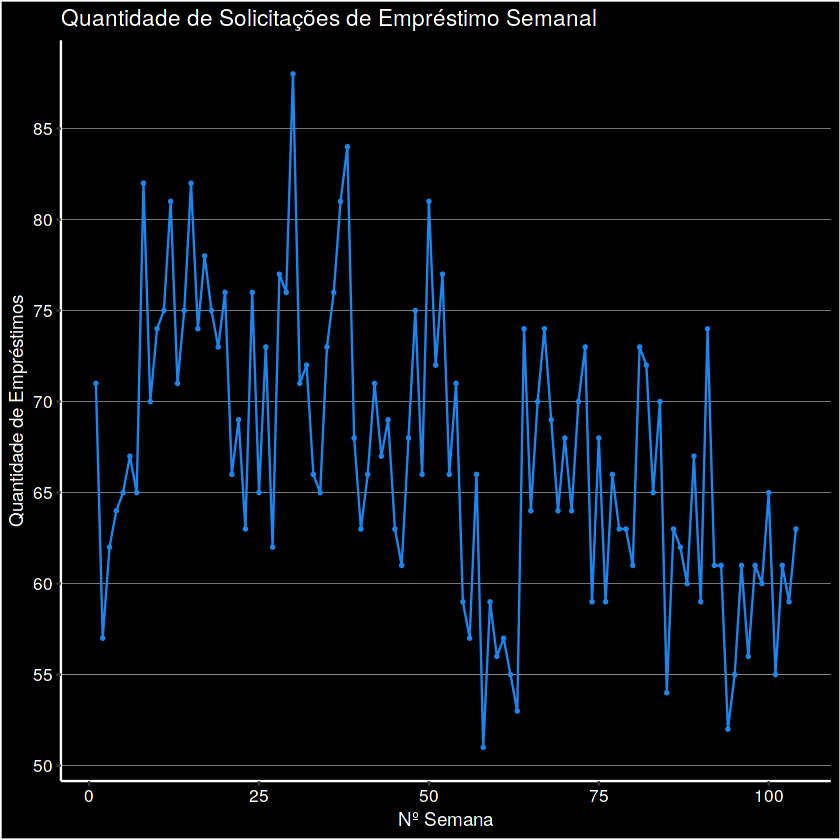

In [9]:
data.frame(num = 1:length(serie), serie) %>% ggplot(aes(num, serie))+
geom_path(colour='dodgerblue2',linetype=1)+geom_point(aes(num,serie),size=0.5,colour='dodgerblue2')+
          labs(title = 'Quantidade de Solicitações de Empréstimo Semanal',
               x= 'Nº Semana', y ='Quantidade de Empréstimos')+tema+
  scale_y_continuous(breaks=seq(0,120,5))

### Realizar o Teste de Estacionariedade - Como o p-value é menor que 0.5, portanto a série é estacionária

In [11]:
adf.test(serie)

Warning message in adf.test(serie):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  serie
Dickey-Fuller = -4.4074, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


# Com a série estácionaria conseguimos realizar o modelo do arima, sabemos que o i está relacionado com a diferenciação, logo i = 0.

# Analisar os gráficos ACF e PACF para verificar os outros parâmetros do Arima.

NULL

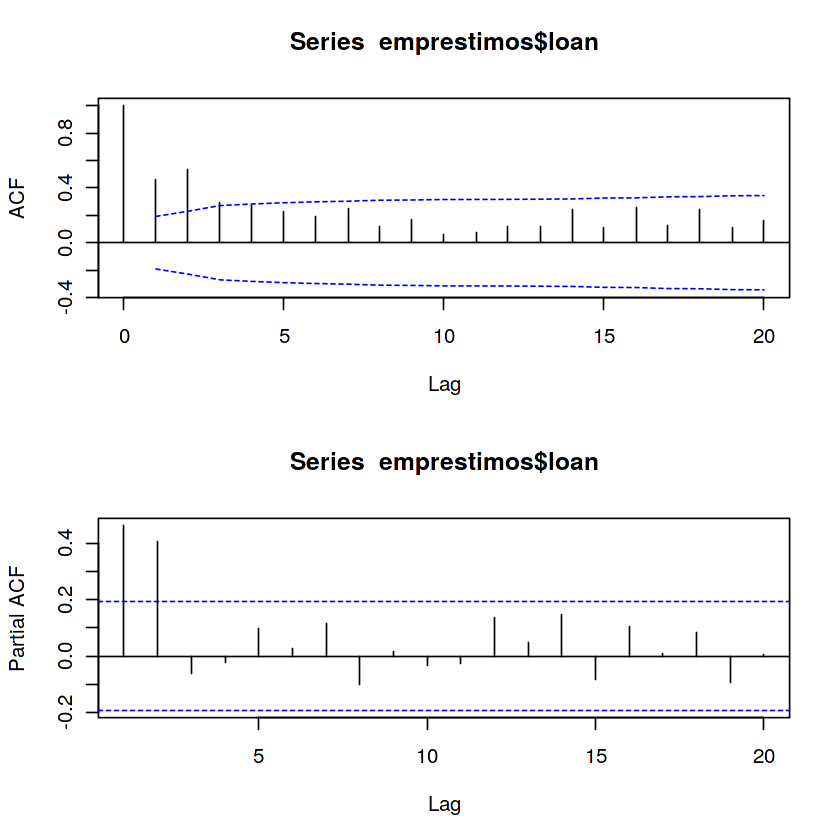

In [12]:
par(mfrow=c(2,1))
acf(emprestimos$loan,ci.type='ma')
pacf(emprestimos$loan)+tema+geom_segment(colour='white')+geom_hline(yintercept = 0,colour='white')

### Separação de Treino e Teste

In [13]:
##treino
df_series_treino <- ts(serie[1:90],frequency = 365.25/7)
##teste
df_series_test <- ts(serie[90:length(serie)],frequency = 365.25/7)
print(paste('n treino:', length(df_series_treino)))

[1] "n treino: 90"


In [14]:
modelo = Arima(df_series_treino,order=c(2,0,0))
  
summary(modelo)

Series: df_series_treino 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
         ar1     ar2     mean
      0.2523  0.3794  67.8779
s.e.  0.0980  0.0990   1.7481

sigma^2 estimated as 40.8:  log likelihood=-293.31
AIC=594.63   AICc=595.1   BIC=604.63

Training set error measures:
                     ME    RMSE      MAE        MPE     MAPE      MASE
Training set 0.02334623 6.28003 4.983141 -0.8279187 7.380827 0.5063085
                   ACF1
Training set 0.03337377


### Análise dos Resíduos

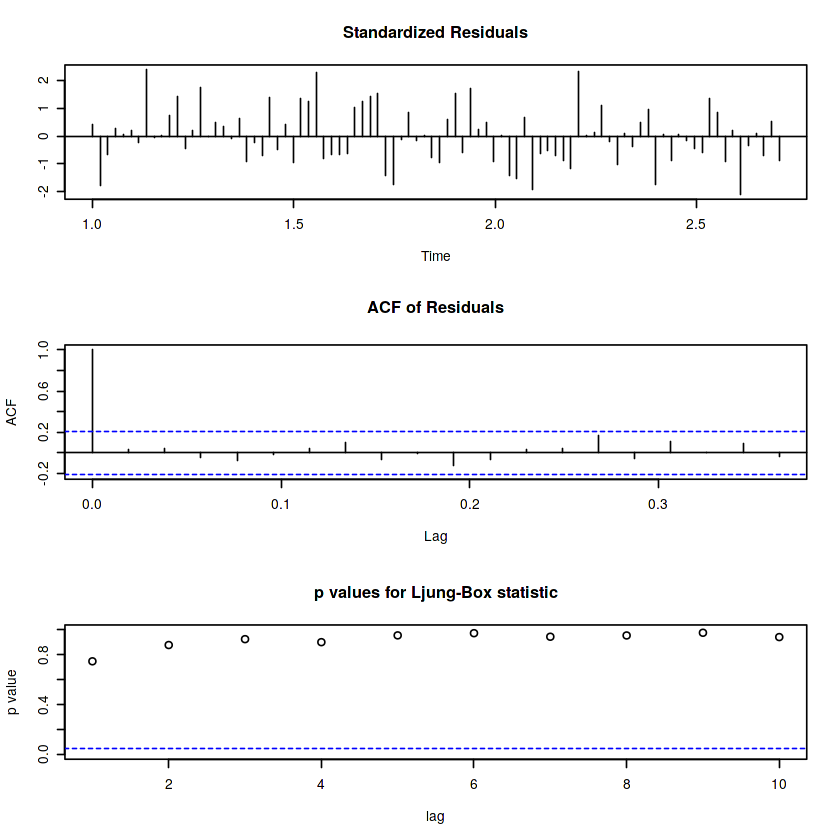

In [15]:
tsdiag(modelo)

Teste de Ruído Branco de Box-Ljung , com as seguintes hipóteses: 

H0 : Há Ruído Branco, modelo não exibe falha de ajuste.
H1 : Não há Ruído Branco, o modelo exibe falha de ajuste.

Regra de decisão: Quando (p-value) é > 0,05 aceitamos H0 , ou seja, há evidência de que o modelo não exibe falha de ajuste.


In [16]:
Box.test(residuals(modelo),type="Ljung-Box")


	Box-Ljung test

data:  residuals(modelo)
X-squared = 0.10362, df = 1, p-value = 0.7475


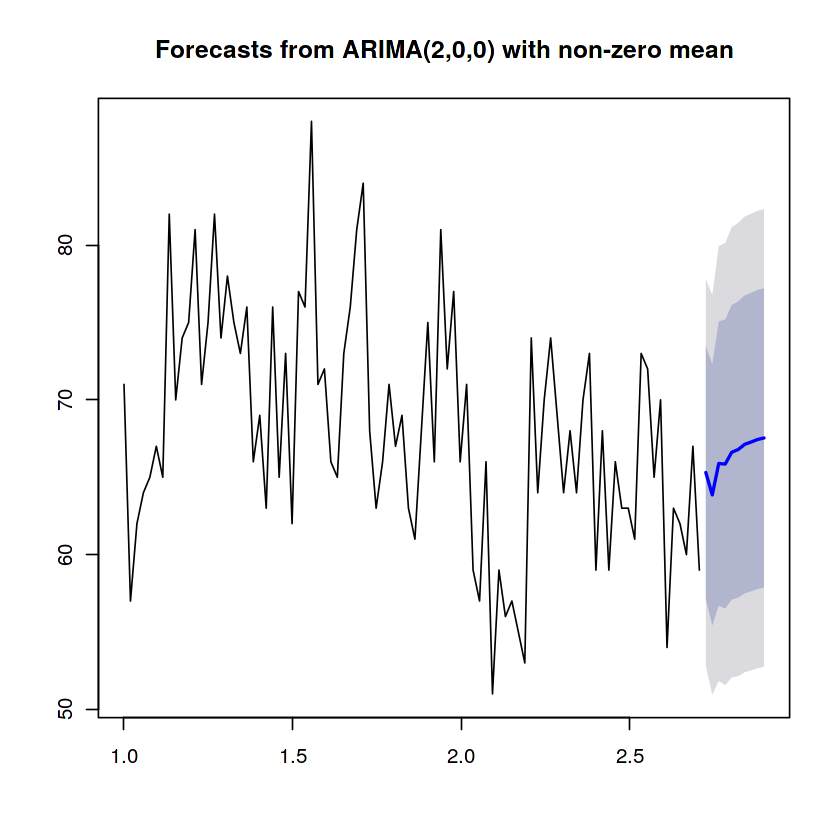

In [17]:
forecasting=forecast::forecast(modelo,h=10)
plot(forecasting)

### Gráfico da série e do previsto

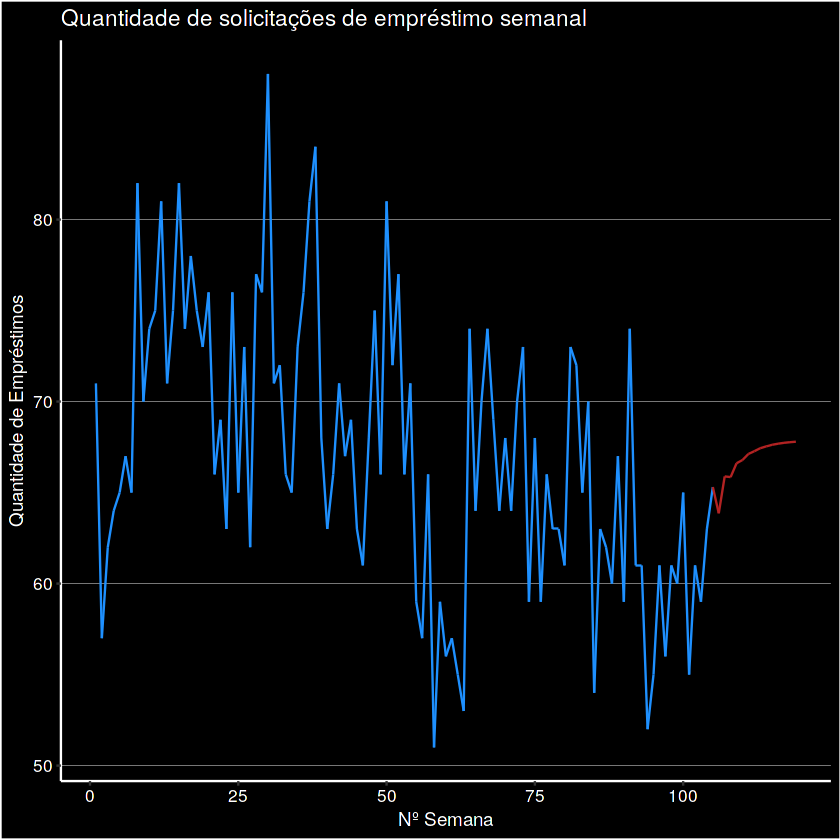

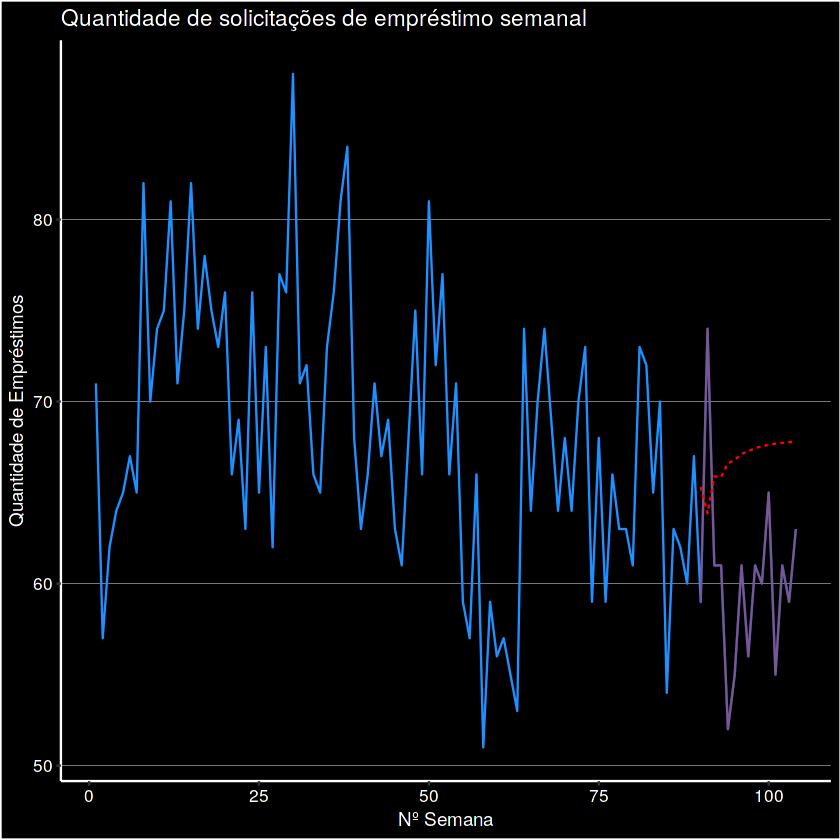

In [18]:
previsoes_arma22 = forecast::forecast(modelo,h=15)

dados_prev = rbind(data.frame(serie = as.double(serie)),
      data.frame(serie = previsoes_arma22$mean)) 

dados_prev = dados_prev %>% mutate(n = 1:119)



dados_prev %>% ggplot(aes(x=n,y = serie))+
  geom_path(colour=ifelse(dados_prev$n<=104,'dodgerblue','firebrick'),linetype=1)+
          labs(title = 'Quantidade de solicitações de empréstimo semanal',
               x= 'Nº Semana', y ='Quantidade de Empréstimos')+tema


df_series_test = data.frame(n=1:length(df_series_test)[1], df_series_test)
df_series_treino = data.frame(n = 1:length(df_series_treino)[1], df_series_treino)
  ##geom_path(colour=ifelse(dados_prev$n<=104,'dodgerblue','firebrick'),linetype=1)+
emprestimos %>% ggplot(aes(x=data,y = loan))+
  geom_path(colour='dodgerblue')+
  geom_path(data=df_series_test,aes(90:104,df_series_test),colour='red',alpha=0.4)+
  geom_path(data= dados_prev[105:119,],aes(x =90:104,y=dados_prev$serie[105:119] ), colour='red',linetype=2)+
  labs(title = 'Quantidade de solicitações de empréstimo semanal',
       x= 'Nº Semana', y ='Quantidade de Empréstimos')+tema